In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from construct import *
import scipy.signal

import sys
sys.path.append('../Tianwen')

import ccsds

import struct
import collections

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.size'] = 14

In [2]:
def load_frames(file):
    frame_size = 220
    frames = np.fromfile(file, dtype = 'uint8')
    return frames[:frames.size//frame_size*frame_size].reshape(-1, frame_size)
    
frames = [load_frames(f) for f in [
    'camras-2022_08_05_08_44_13_tlm_frames.u8',
    'camras-2022_08_05_13_53_49_tlm_frames.u8',
    'camras-2022_08_05_14_08_18_tlm_frames.u8',
]]
[f.shape[0] for f in frames]

[1387, 120, 3207]

In [3]:
recording_number = np.zeros(np.sum([f.shape[0] for f in frames]), 'int')
num_recordings = len(frames)
b = 0
for a in [f.shape[0] for f in frames]:
    b += a
    recording_number[b:] += 1
frames = np.concatenate(frames)

In [4]:
aos = [ccsds.AOSPrimaryHeader.parse(f) for f in frames]
scid = np.array([a.spacecraft_id for a in aos])
vcid = np.array([a.virtual_channel_id for a in aos])
framecount = np.array([a.virtual_channel_frame_count for a in aos])

In [5]:
aos[:10]

[Container(transfer_frame_version_number=1, spacecraft_id=187, virtual_channel_id=34, virtual_channel_frame_count=32096, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=187, virtual_channel_id=35, virtual_channel_frame_count=32095, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=187, virtual_channel_id=36, virtual_channel_frame_count=32088, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=187, virtual_channel_id=33, virtual_channel_frame_count=32077, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=187, virtual_channel_id=34, virtual_channel_frame_count=32097, replay_flag=False, vc_frame_count_u

In [6]:
collections.Counter(scid), hex(187)

(Counter({187: 4713, 152: 1}), '0xbb')

In [7]:
collections.Counter([v for v,s in zip(vcid, scid) if s == 0xbb])

Counter({34: 1180, 35: 1178, 36: 1177, 33: 1178})

In [8]:
vcids = [33, 34, 35, 36]

In [9]:
packet_hdrs = {
    vc: [
        ccsds.SpacePacketPrimaryHeader.parse(bytes(f[8:]))
        for f in frames[vcid == vc]
    ]
    for vc in vcids
}

In [10]:
for vc in vcids:
    print('VCID', vc)
    print(packet_hdrs[vc][:3])
    print()

VCID 33
[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=673, sequence_flags=3, packet_sequence_count_or_name=15693, data_length=205), Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=673, sequence_flags=3, packet_sequence_count_or_name=15694, data_length=205), Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=673, sequence_flags=3, packet_sequence_count_or_name=15695, data_length=205)]

VCID 34
[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=674, sequence_flags=3, packet_sequence_count_or_name=15712, data_length=205), Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=674, sequence_flags=3, packet_sequence_count_or_name=15713, data_length=205), Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=674, sequence_flags=3, packet_sequence_count_or_name=15714, data_length=205)]

VCID 35
[Container(ccsds_version=0, packet_type=0, secon

In [11]:
# 5 byte timecode
timecode = (
    frames[:, 8+6+2:8+6+6].view('uint32').ravel().byteswap().astype('uint64')
    + (frames[:, 8+6+1].astype('uint64') << 32)
)
timecode &= 0xffffff # use only 24 bits
timecode_s = timecode.astype('float') / 8
timecode_dt = np.datetime64('2022-07-30T12:00') + np.timedelta64(1, 'ns') * (timecode_s * 1e9)

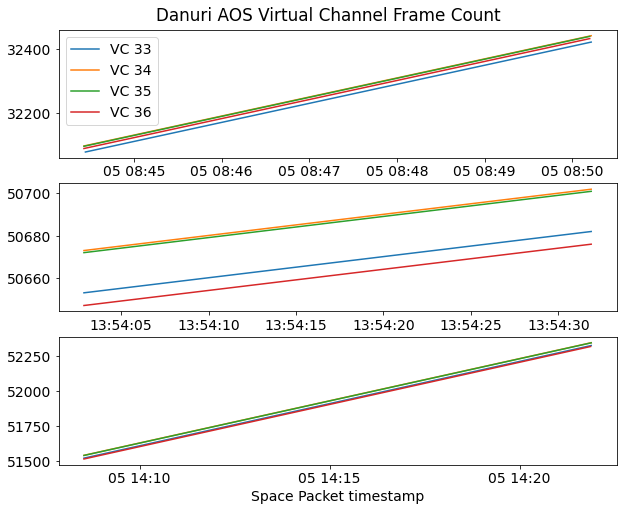

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
for recording in range(num_recordings):
    for vc in vcids:
        axs[recording].plot(
            timecode_dt[recording_number==recording][vcid[recording_number==recording]==vc],
            framecount[recording_number==recording][vcid[recording_number==recording]==vc])
axs[0].legend([f'VC {vc}' for vc in vcids])
fig.suptitle('Danuri AOS Virtual Channel Frame Count', y=0.92)
axs[-1].set_xlabel('Space Packet timestamp');

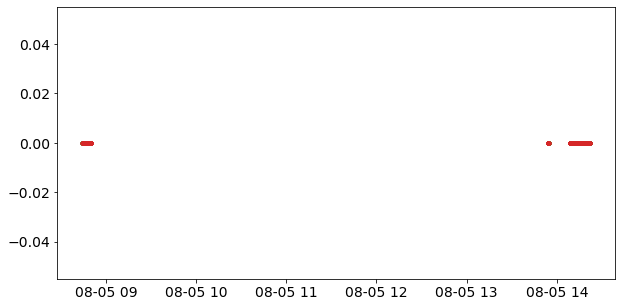

In [13]:
for vc in vcids:
    plt.plot(
        timecode_dt[vcid == vc],
        (framecount[vcid == vc] 
         - np.array([h.packet_sequence_count_or_name for h in packet_hdrs[vc]])) % 2**14, '.')

In [14]:
for recording in range(num_recordings):
    for vc in vcids:
        loss = np.sum(np.diff(framecount[recording_number==recording][vcid[recording_number==recording]==vc]) - 1)
        print(f'Recording {recording} VC {vc}, frame loss: {loss}')

Recording 0 VC 33, frame loss: 1
Recording 0 VC 34, frame loss: 0
Recording 0 VC 35, frame loss: 1
Recording 0 VC 36, frame loss: 1
Recording 1 VC 33, frame loss: 0
Recording 1 VC 34, frame loss: 0
Recording 1 VC 35, frame loss: 0
Recording 1 VC 36, frame loss: 0
Recording 2 VC 33, frame loss: 0
Recording 2 VC 34, frame loss: 0
Recording 2 VC 35, frame loss: 0
Recording 2 VC 36, frame loss: 0


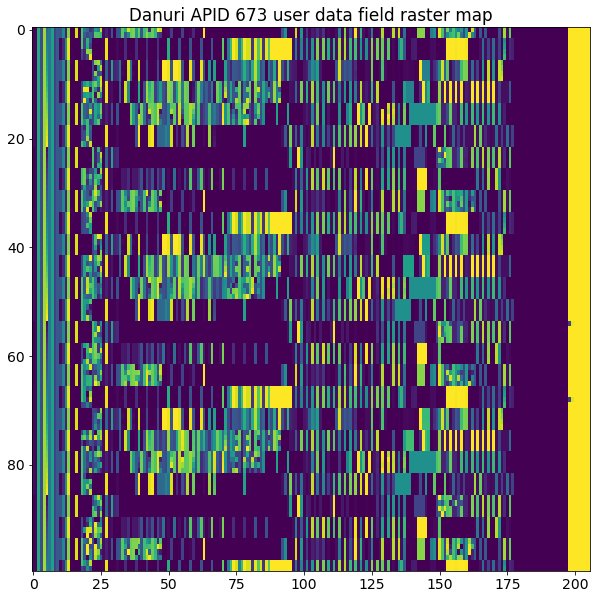

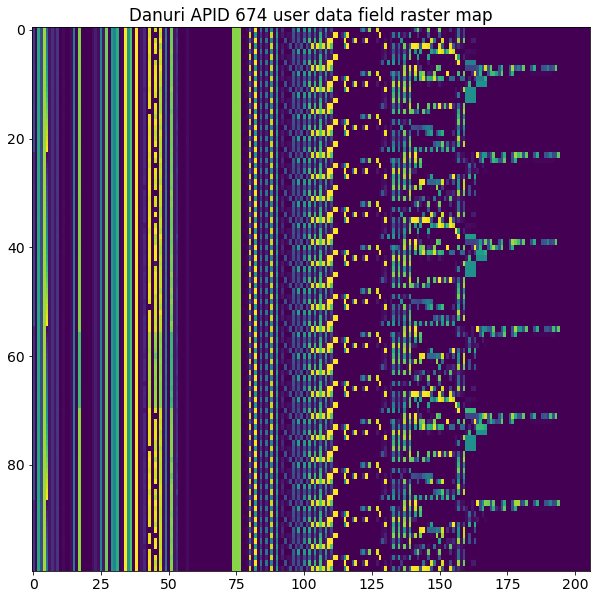

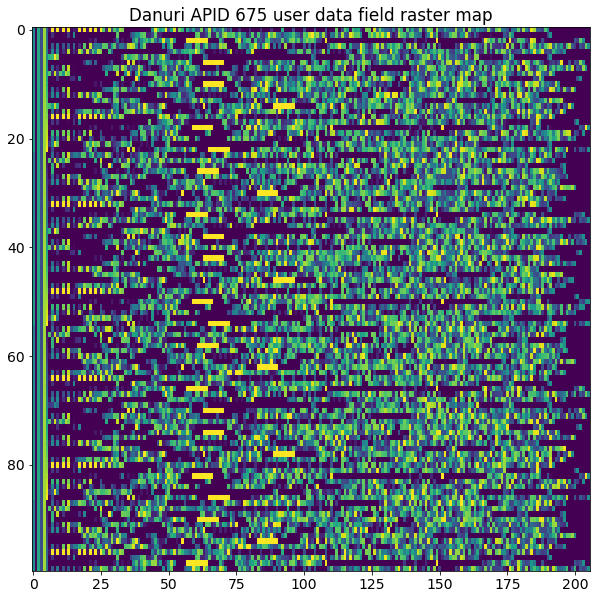

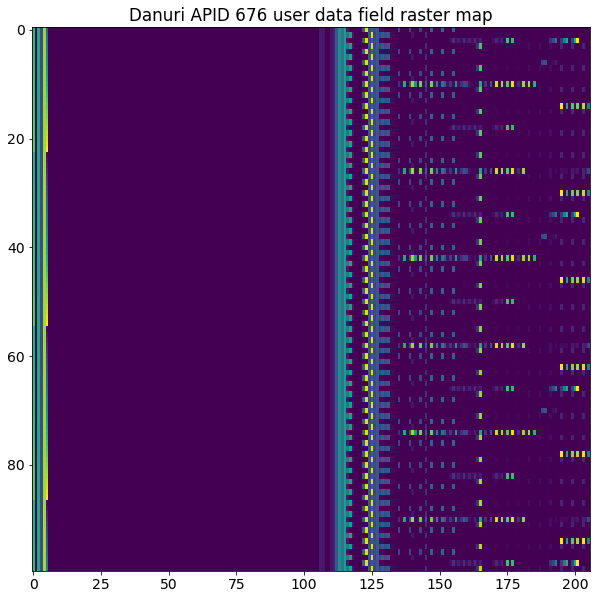

In [15]:
for vc in vcids:
    plt.figure(figsize=(10, 10))
    plt.imshow(frames[vcid==vc, 8+6:][:100, :], aspect='auto', interpolation='none')
    plt.title(f'Danuri APID {vc + 640} user data field raster map')

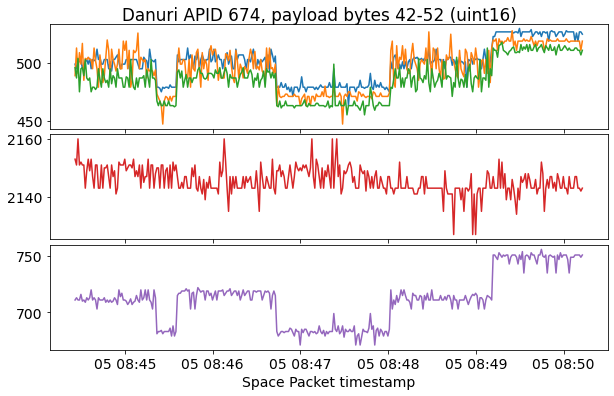

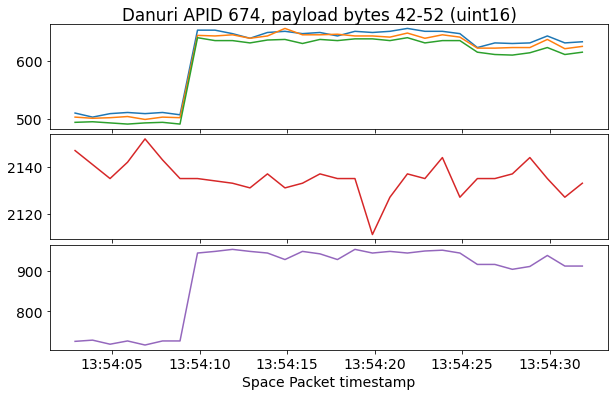

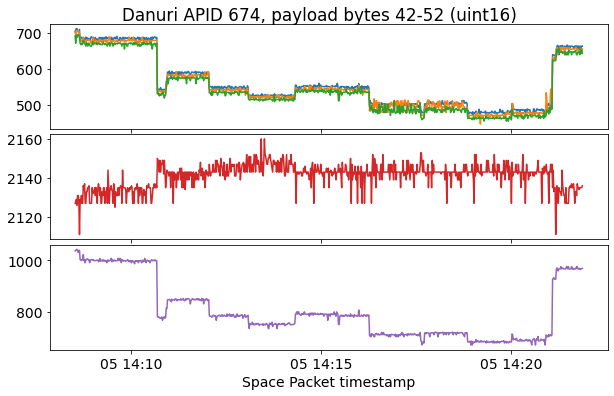

In [16]:
for recording in range(num_recordings):
    fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
    t = timecode_dt[recording_number==recording][vcid[recording_number==recording]==34]
    axs[0].plot(t,
                frames[recording_number==recording][vcid[recording_number==recording]==34, 8+6:][:, 42:48]
                .view('uint16').byteswap())
    axs[1].plot(t,
                frames[recording_number==recording][vcid[recording_number==recording]==34, 8+6:][:, 48:50]
                .view('uint16').byteswap(),
                color='C3')
    axs[2].plot(t,
                frames[recording_number==recording][vcid[recording_number==recording]==34, 8+6:][:, 50:52]
                .view('uint16').byteswap(),
                color='C4')
    axs[2].set_xlabel('Space Packet timestamp')
    plt.subplots_adjust(hspace=0.05)
    plt.suptitle('Danuri APID 674, payload bytes 42-52 (uint16)', y=0.92);